In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
import astropy.units as u
from astropy.utils.console import ProgressBar

from rms import STSP, Star, Spot

In [2]:
t0 = 2454605.8914
rotation_period = 25

transit_times = Time(t0, format='jd') + np.arange(-3/24, 3/24, 1/30/24) * u.day

sun_with_h11b = Star(rotation_period=rotation_period, planet=True)

In [3]:
n_transits = 10
fluxes = np.zeros((len(transit_times), n_transits))
times = np.zeros((len(transit_times), n_transits))

no_transit_spot = Spot(radius=0.0001, latitude=-88*u.deg, longitude=0*u.deg)

with ProgressBar(n_transits, ipython_widget=True) as bar:
    for i in range(n_transits):
        
        # Draw spots from the sunspot distribution
        n_spots = 8
        spots = [Spot.from_sunspot_distribution() for i in range(n_spots)]

        # Draw observing times from uniform distribution
        random_times = transit_times + 1 * (np.random.rand() - 0.5) * u.min
        
        with STSP(random_times, sun_with_h11b, spots) as stsp: 
            lc = stsp.generate_lightcurve(n_ld_rings=100)
            
        with STSP(random_times, sun_with_h11b, no_transit_spot) as stsp: 
            no_spot_lc = stsp.generate_lightcurve(n_ld_rings=100)
        
        oot_fluxes = lc.mask_out_of_transit(sun_with_h11b, flip=True)['fluxes']
        median_oot_flux = np.median(oot_fluxes)
        
        fluxes[:, i] = lc.fluxes / median_oot_flux - no_spot_lc.fluxes
        times[:, i] = random_times.jd
        
        bar.update()

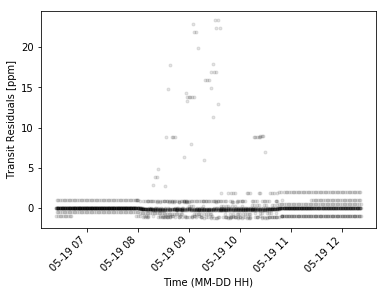

In [4]:
mf = np.median(fluxes, axis=1)

for t, f in zip(times.T, fluxes.T):    
    plt.plot_date(Time(t, format='jd').plot_date, f*1e6, fmt='.', alpha=0.1, color='k')
#plt.ylim([-0.003, 0.001])
ax = plt.gca()
ax.set(xlabel='Time (MM-DD HH)', ylabel='Transit Residuals [ppm]')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('sun_with_h11_residuals.png', bbox_inches='tight', dpi=150)

In [5]:
x = times.ravel()
y = fluxes.ravel()
yerr = np.ones_like(y) * 1e-6

<Container object of 3 artists>

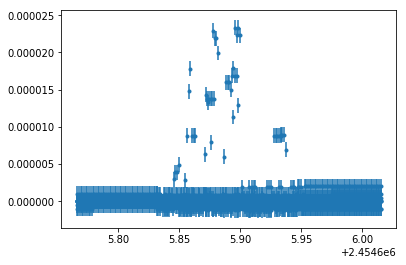

In [12]:
plt.errorbar(x, y, yerr, fmt='.')

In [76]:
import emcee
from scipy.misc import logsumexp

default_mean = 0
default_amp = 1

def gaussian(x, mean, lnvar, amp):
    var = np.exp(lnvar)
    return amp/np.sqrt(2*np.pi*var) * np.exp(-0.5 * (x - mean)**2 / var)

def lnlikelihood_gaussian(parameters, y, yerr, mean=default_mean, amp=default_amp):
    lnvar = parameters[0]
    var = np.exp(lnvar) + yerr**2
    return np.sum(-0.5 * ((y - mean)**2 / var + np.log(var)) + np.log(amp))

def model(parameters, x, mean=default_mean, amp=default_amp):
    lnvar = parameters[0]
    return gaussian(x, mean, lnvar, amplitude)

def lnprior(parameters):
    lnvar = parameters[0]
    if (-100 < lnvar < 1):
        return 0.0
    return -np.inf

def lnprob(parameters, y, yerr):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    lnlike = lnlikelihood_gaussian(parameters, y, yerr)
    return lp + lnlike

In [77]:
import emcee

initp = [1e-3]

ndim, nwalkers = len(initp), 4*len(initp)
p0 = [np.array(initp) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(y, yerr),
                                threads=4)

pos = sampler.run_mcmc(p0, 50)[0]
samples = sampler.run_mcmc(pos, 1000)

In [78]:
lnvar_samples = sampler.flatchain.ravel()

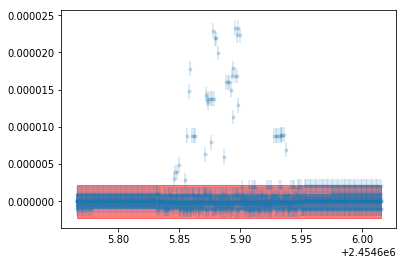

In [79]:
x_model = np.linspace(x.min(), x.max(), 100)
y_model = np.ones_like(x_model) * np.exp(np.median(lnvar_samples))**0.5

plt.errorbar(x, y, yerr, fmt='.', alpha=0.2)
plt.fill_between(x_model, 0, y_model, alpha=0.5, color='r')
plt.fill_between(x_model, -y_model, 0, alpha=0.5, color='r')